In [1]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

os.chdir("/content/drive/MyDrive/Colab Notebooks/gi-disease-detection")

# Loading and Cleaning the Dataset

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import Dataset
import os
import cv2
import numpy as np

In [4]:
SOURCE = "local"
BATCH_SIZE = 32
RAW_DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/gi-disease-detection/raw_data"
IMAGE_RESCALE_RATIO = 1. / 255
IMAGE_TARGET_WIDTH = 224
IMAGE_TARGET_HEIGHT = 224

In [5]:
def load_images(path, class_mode = "categorical"):
    """
    Enter a path to load images from.
    class_mode should be "categorical" if we are calling this function on data with existing categories.
    class_mode should be None if we are calling this function on new data.
    """
    datagen = ImageDataGenerator(rescale = float(IMAGE_RESCALE_RATIO))
    images = datagen.flow_from_directory(path,
                                         target_size = (int(IMAGE_TARGET_WIDTH), int(IMAGE_TARGET_HEIGHT)),
                                         color_mode = "rgb",
                                         batch_size = int(BATCH_SIZE),
                                         class_mode = class_mode)

    return images

In [6]:
def convert_DI_to_numpy(dataset):
    """
    Converts DirectoryIterator dataset to numpy.array.
    Returns X and y values for each dataset.
    """
    X = np.concatenate([dataset.next()[0] for i in range(dataset.__len__())])
    y = np.concatenate([dataset.next()[1] for i in range(dataset.__len__())])

    return X, y

In [7]:
def train_val_test_generator(source = SOURCE):
    """
    Generate the train, validation, and test datasets.
    Also generates the X and y for train, validation, and test.
    """
    if source == "local":
        train_directory = os.path.join(RAW_DATA_PATH, "train")
        val_directory = os.path.join(RAW_DATA_PATH, "val")
        test_directory = os.path.join(RAW_DATA_PATH, "test")

    #this doesn't work right now
    if source == "cloud":
        credentials = service_account.Credentials.from_service_account_file(GOOGLE_APPLICATION_CREDENTIALS)
        client = storage.Client(project = GCLOUD_PROJECT_ID, credentials = credentials)
        bucket = client.get_bucket(BUCKET_NAME)

        train_directory = f"gs://{BUCKET_NAME}/train"
        val_directory = f"gs://{BUCKET_NAME}/val"
        test_directory = f"gs://{BUCKET_NAME}/test"

    X_train, y_train = convert_DI_to_numpy(load_images(train_directory, class_mode = "categorical"))
    X_val, y_val = convert_DI_to_numpy(load_images(val_directory, class_mode = "categorical"))
    X_test, y_test = convert_DI_to_numpy(load_images(test_directory, class_mode = "categorical"))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
def preprocess_images(X: np.array):
    """
    Clean the images in X_train, X_val, and X_test.
    """
    def clean_image(image: np.array):
        """
        Input an image to add a rectangle to cover the green or black box on the resized and normalized image (-1 box).
        """
        # Identified ROI in resized and normalized image
        y1 = 148
        y2 = 224
        x1 = 0
        x2 = 77

        image_clean = cv2.rectangle(image, (x1, y1), (x2, y2), (-1, -1, -1), -1)

        return image_clean

    cleaned_X = []

    for i in range(X.shape[0]):
        cleaned_X.append(clean_image(X[i, :, :, :]))

    return cleaned_X

In [9]:
def convert_numpy_to_TFDataset(X, y):
    """
    Converts numpy.array back to TF format but this time a TF dataset.
    """
    dataset = Dataset.from_tensor_slices((X, y)).batch(int(BATCH_SIZE))

    return dataset

In [10]:
def pipeline():
    """
    A pipeline of the entire cleaning process.
    """
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_generator(source = SOURCE)

    preprocessed_train = preprocess_images(X_train)
    preprocessed_val = preprocess_images(X_val)
    preprocessed_test = preprocess_images(X_test)

    train_dataset = convert_numpy_to_TFDataset(preprocessed_train, y_train)
    val_dataset = convert_numpy_to_TFDataset(preprocessed_val, y_val)
    test_dataset = convert_numpy_to_TFDataset(preprocessed_test, y_test)

    return train_dataset, val_dataset, test_dataset

In [11]:
train_dataset, val_dataset, test_dataset = pipeline()

Found 2400 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [12]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [13]:
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [14]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# ResNet50

In [15]:
from tensorflow import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import Sequential, layers
from keras.callbacks import EarlyStopping

In [16]:
# Cfg0 Block
cfg0_conv_input = keras.Input(shape=(56,56,64), name='cfg0_conv')
x = keras.layers.Conv2D(64, kernel_size=1, strides=1, activation='relu', padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (cfg0_conv_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

cfg0_conv_input_transform = keras.layers.Conv2D(256, kernel_size=1, strides=1, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (cfg0_conv_input)
cfg0_conv_input_op = keras.layers.BatchNormalization()(cfg0_conv_input_transform)
x = keras.layers.Add()([x, cfg0_conv_input_op])
cfg0_conv_output = keras.layers.ReLU()(x)

cfg0_conv = keras.Model(inputs=cfg0_conv_input, outputs=cfg0_conv_output, name='cfg0_conv')




cfg0_identity_input = keras.Input(shape=(56, 56, 256), name='cfg0_identity')
x = keras.layers.Conv2D(64, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (cfg0_identity_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Add()([x, cfg0_identity_input])
cfg0_identity_output = keras.layers.ReLU()(x)

cfg0_identity = keras.Model(inputs=cfg0_identity_input, outputs=cfg0_identity_output, name='cfg0_identity_p1')




cfg0_input = keras.Input(shape=(56, 56, 64), name='cfg0')
x = cfg0_conv(cfg0_input)
x = cfg0_identity(x)
cfg0_output = cfg0_identity(x)

cfg0 = keras.Model(inputs=cfg0_input, outputs=cfg0_output, name='cfg0_block')

In [17]:
# Cfg1 Block
cfg1_conv_input = keras.Input(shape=(56, 56, 256), name='cfg1_conv')
x = keras.layers.Conv2D(128, kernel_size=1, strides=2, activation='relu', padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (cfg1_conv_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(512, kernel_size=1, strides=1, padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

cfg1_conv_input_transform = keras.layers.Conv2D(512, kernel_size=1, strides=2, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (cfg1_conv_input)
cfg1_conv_input_output = keras.layers.BatchNormalization()(cfg1_conv_input_transform)
x = keras.layers.Add()([x, cfg1_conv_input_output])
cfg1_conv_output = keras.layers.ReLU()(x)

cfg1_conv = keras.Model(inputs=cfg1_conv_input, outputs=cfg1_conv_output, name='cfg1_conv')




cfg1_identity_input = keras.Input(shape=(28, 28, 512), name='cfg1_identity')
x = keras.layers.Conv2D(128, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (cfg1_identity_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(512, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Add()([x, cfg1_identity_input])
cfg1_identity_output = keras.layers.ReLU()(x)

cfg1_identity = keras.Model(inputs=cfg1_identity_input, outputs=cfg1_identity_output, name='cfg1_identity_p1')


cfg1_input = keras.Input(shape=(56, 56, 256), name='cfg1')
x = cfg1_conv(cfg1_input)
x = cfg1_identity(x)
x = cfg1_identity(x)
cfg1_output = cfg1_identity(x)

cfg1 = keras.Model(inputs=cfg1_input, outputs=cfg1_output, name='cfg1_block')

In [18]:
# Cfg2 Block
cfg2_conv_input = keras.Input(shape=(28, 28, 512), name='cfg2_conv')
x = keras.layers.Conv2D(256, kernel_size=1, strides=2, activation='relu', padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (cfg2_conv_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, kernel_size=3, strides=1, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(1024, kernel_size=1, strides=1, padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

cfg2_conv_input_transform = keras.layers.Conv2D(1024, kernel_size=1, strides=2, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (cfg2_conv_input)
cfg2_conv_input_output = keras.layers.BatchNormalization()(cfg2_conv_input_transform)
x = keras.layers.Add()([x, cfg2_conv_input_output])
cfg2_conv_output = keras.layers.ReLU()(x)

cfg2_conv = keras.Model(inputs=cfg2_conv_input, outputs=cfg2_conv_output, name='cfg2_conv')




cfg2_identity_input = keras.Input(shape=(14, 14, 1024), name='cfg2_identity')
x = keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (cfg2_identity_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(1024, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Add()([x, cfg2_identity_input])
cfg2_identity_output = keras.layers.ReLU()(x)

cfg2_identity = keras.Model(inputs=cfg2_identity_input, outputs=cfg2_identity_output, name='cfg2_identity_p1')


cfg2_input = keras.Input(shape=(28, 28, 512), name='cfg2')
x = cfg2_conv(cfg2_input)
x = cfg2_identity(x)
x = cfg2_identity(x)
x = cfg2_identity(x)
x = cfg2_identity(x)
cfg2_output = cfg2_identity(x)

cfg2 = keras.Model(inputs=cfg2_input, outputs=cfg2_output, name='cfg2_block')

In [19]:
# Cfg3 Block
cfg3_conv_input = keras.Input(shape=(14, 14, 1024), name='cfg3_conv')
x = keras.layers.Conv2D(512, kernel_size=1, strides=2, activation='relu', padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (cfg3_conv_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(512, kernel_size=3, strides=1, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(2048, kernel_size=1, strides=1, padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

cfg3_conv_input_transform = keras.layers.Conv2D(2048, kernel_size=1, strides=2, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (cfg3_conv_input)
cfg3_conv_input_output = keras.layers.BatchNormalization()(cfg3_conv_input_transform)
x = keras.layers.Add()([x, cfg3_conv_input_output])
cfg3_conv_output = keras.layers.ReLU()(x)

cfg3_conv = keras.Model(inputs=cfg3_conv_input, outputs=cfg3_conv_output, name='cfg3_conv')




cfg3_identity_input = keras.Input(shape=(7, 7, 2048), name='cfg3_identity')
x = keras.layers.Conv2D(512, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (cfg3_identity_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(2048, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Add()([x, cfg3_identity_input])
cfg3_identity_output = keras.layers.ReLU()(x)

cfg3_identity = keras.Model(inputs=cfg3_identity_input, outputs=cfg3_identity_output, name='cfg3_identity_p1')


cfg3_input = keras.Input(shape=(14, 14, 1024), name='cfg3')
x = cfg3_conv(cfg3_input)
x = cfg3_identity(x)
cfg3_output = cfg3_identity(x)

cfg3 = keras.Model(inputs=cfg3_input, outputs=cfg3_output, name='cfg3_block')

In [20]:
# Classifier block
classifier_input = keras.Input(shape=(7, 7, 2048), name='classifier')
x = keras.layers.AveragePooling2D(pool_size=2, padding='same')(classifier_input)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
classifier_output = keras.layers.Dense(3, activation='softmax', kernel_constraint=keras.constraints.max_norm(2.))(x)

classifier = keras.Model(inputs=classifier_input, outputs=classifier_output, name='classifier')

In [30]:
# Build model
def build_resnet_model():
    resnet_input = keras.Input(shape=(224, 224, 3), name='input')
    #x = imageAug(resnet_input)
    x = keras.layers.Conv2D(64, kernel_size=7, activation='relu', padding='same', strides=2, kernel_constraint=keras.constraints.max_norm(2.))(resnet_input)
    conv1_output = keras.layers.MaxPooling2D(pool_size=3, padding='same', strides=2) (x)
    x = cfg0(conv1_output)
    x = cfg1(x)
    x = cfg2(x)
    x = cfg3(x)
    model_output = classifier(x)
    resnet_model = keras.Model(inputs=resnet_input, outputs=model_output, name='resnet50')

    print(resnet_model.summary())

    recall = keras.metrics.Recall()

    resnet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy', recall],
    )
    
    return resnet_model

In [31]:
model_resnet_1 = build_resnet_model()

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_30 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 cfg0_block (Functional)     (None, 56, 56, 256)       148480    
                                                                 
 cfg1_block (Functional)     (None, 28, 28, 512)       665600    
                                                                 
 cfg2_block (Functional)     (None, 14, 14, 1024)      2641920   
                                                          

In [36]:
es = EarlyStopping(patience=10, restore_best_weights=True)
es_recall = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_recall_2', mode='max')
adam_opt = optimizers.Adam(learning_rate=0.0001)
adam_opt_1 = optimizers.Adam(learning_rate=0.01)
adam_opt_2 = optimizers.Adam(learning_rate=0.005)
adam_opt_3 = optimizers.Adam(learning_rate=1)

In [37]:
history = model_resnet_1.fit(train_dataset,
                epochs=100,
                callbacks=[es_recall],
                validation_data=val_dataset)

Epoch 1/100
75/75 [==============================] - 34s 455ms/step - loss: 2.0224 - accuracy: 0.3508 - recall_2: 0.3113 - val_loss: 3.3186 - val_accuracy: 0.3300 - val_recall_2: 0.3247
Epoch 2/100
75/75 [==============================] - 33s 444ms/step - loss: 1.7434 - accuracy: 0.3417 - recall_2: 0.2887 - val_loss: 1.4308 - val_accuracy: 0.3240 - val_recall_2: 0.2247
Epoch 3/100
75/75 [==============================] - 34s 452ms/step - loss: 1.8011 - accuracy: 0.3300 - recall_2: 0.2862 - val_loss: 1.7077 - val_accuracy: 0.3340 - val_recall_2: 0.2993
Epoch 4/100
75/75 [==============================] - 33s 444ms/step - loss: 1.5927 - accuracy: 0.3475 - recall_2: 0.2954 - val_loss: 1.4034 - val_accuracy: 0.3300 - val_recall_2: 0.2193
Epoch 5/100
75/75 [==============================] - 33s 444ms/step - loss: 1.5524 - accuracy: 0.3388 - recall_2: 0.2754 - val_loss: 1.3270 - val_accuracy: 0.3327 - val_recall_2: 0.2060
Epoch 6/100
75/75 [==============================] - 33s 445ms/step - 

In [38]:
model_resnet_1.evaluate(test_dataset)

19/19 [==============================] - 3s 132ms/step - loss: 3.3900 - accuracy: 0.3417 - recall_2: 0.3400


[3.390026330947876, 0.34166666865348816, 0.3400000035762787]

In [39]:
predictions = model_resnet_1.predict(test_dataset)

19/19 [==============================] - 3s 96ms/step


In [52]:
predictions[:10]

,0,1,2
0,0.012087,0.984894,0.003019
1,0.111339,0.853187,0.035474
2,0.006889,0.990190,0.002921
3,0.013220,0.979775,0.007006
4,0.019355,0.979823,0.000822
5,0.046366,0.949853,0.003781
6,0.109479,0.636290,0.254231
7,0.005748,0.993867,0.000385
8,0.001381,0.998024,0.000595
9,0.142265,0.770320,0.087416


In [42]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

In [53]:
y_true[0:10]

array([2, 1, 0, 0, 1, 2, 0, 2, 1, 1])

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [45]:
predictions = pd.DataFrame(predictions)

In [46]:
y_pred = np.array(predictions.idxmax(1))

In [47]:
y_pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
y_true = pd.DataFrame(y_true)

In [50]:
y_true = np.array(y_true.idxmax(1))

In [51]:
y_true[:10]

array([2, 1, 0, 0, 1, 2, 0, 2, 1, 1])

In [54]:
cm = confusion_matrix(y_true, y_pred, normalize = "true")

In [55]:
classes = ["normal", "UC", "polyps"]

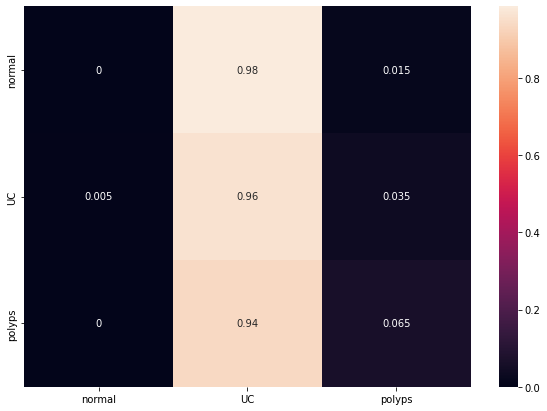

In [56]:
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10, 7))
cm_plot = sns.heatmap(df_cm, annot = True);

In [57]:
cm_plot.figure.savefig("cm_resnet.png")

# Baseline CNN model

In [59]:
es = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
recall = keras.metrics.Recall()
optimizer = optimizers.Adam(learning_rate = 0.001)

In [78]:
model_2 = Sequential()

model_2.add(layers.Conv2D(128, kernel_size=(3,3), input_shape = (224, 224, 3), activation='relu', padding='same'))
model_2.add(layers.Conv2D(128, kernel_size = (3, 3), activation = "relu"))
model_2.add(layers.MaxPool2D(pool_size=(3,3)))
model_2.add(layers.Dropout(0.3))

model_2.add(layers.Conv2D(128, kernel_size=(2,2), activation='relu'))
model_2.add(layers.Conv2D(128, kernel_size=(2,2), activation='relu'))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

model_2.add(layers.Conv2D(64, kernel_size=(2,2), activation='relu'))
model_2.add(layers.Conv2D(64, kernel_size=(2,2), activation='relu'))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))
model_2.add(layers.Dropout(0.2))

model_2.add(layers.Flatten())

model_2.add(layers.Dense(64, activation='relu'))
# model_2.add(layers.Dense(32, activation='relu'))

model_2.add(layers.Dense(3, activation='softmax'))

In [79]:
model_2.compile(loss='categorical_crossentropy',
            optimizer=optimizer,
            metrics=[recall, 'accuracy'])

In [80]:
history_2 = model_2.fit(train_dataset,
    validation_data=val_dataset,
    epochs=10,
    batch_size = BATCH_SIZE,
    callbacks=[es],
    verbose=1)

Epoch 1/10
75/75 [==============================] - 36s 457ms/step - loss: 1.1517 - recall_3: 0.0072 - accuracy: 0.3233 - val_loss: 1.0987 - val_recall_3: 0.0000e+00 - val_accuracy: 0.3333
Epoch 2/10
75/75 [==============================] - 33s 446ms/step - loss: 1.0990 - recall_3: 0.0000e+00 - accuracy: 0.3183 - val_loss: 1.0987 - val_recall_3: 0.0000e+00 - val_accuracy: 0.3333
Epoch 3/10
75/75 [==============================] - 33s 443ms/step - loss: 1.0989 - recall_3: 0.0000e+00 - accuracy: 0.3225 - val_loss: 1.0986 - val_recall_3: 0.0000e+00 - val_accuracy: 0.3333
Epoch 4/10
75/75 [==============================] - 33s 446ms/step - loss: 1.0989 - recall_3: 0.0000e+00 - accuracy: 0.3229 - val_loss: 1.0986 - val_recall_3: 0.0000e+00 - val_accuracy: 0.3333
Epoch 5/10
75/75 [==============================] - 33s 445ms/step - loss: 1.0989 - recall_3: 0.0000e+00 - accuracy: 0.3167 - val_loss: 1.0986 - val_recall_3: 0.0000e+00 - val_accuracy: 0.3333
Epoch 6/10
75/75 [=====================

In [16]:
model_2.evaluate(test_dataset)

19/19 [==============================] - 1s 30ms/step - loss: 1.0986 - recall: 0.0000e+00 - accuracy: 0.3333


[1.0986186265945435, 0.0, 0.3333333432674408]

In [17]:
predictions_2 = model_2.predict(test_dataset)

19/19 [==============================] - 0s 16ms/step


In [18]:
predictions_2[0]

array([0.3319535 , 0.33511373, 0.33293277], dtype=float32)

In [21]:
predictions_2 = pd.DataFrame(predictions_2)

In [22]:
y_pred_2 = np.array(predictions_2.idxmax(1))

In [23]:
y_pred_2[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [24]:
y_test_2 = pd.DataFrame(y_test)

In [25]:
y_test_2 = np.array(y_test_2.idxmax(1))

In [26]:
y_test_2[:10]

array([0, 1, 1, 2, 2, 2, 2, 0, 1, 0])

In [27]:
cm_2 = confusion_matrix(y_test_2, y_pred_2, normalize = "true")

In [28]:
classes = ["normal", "UC", "polyps"]

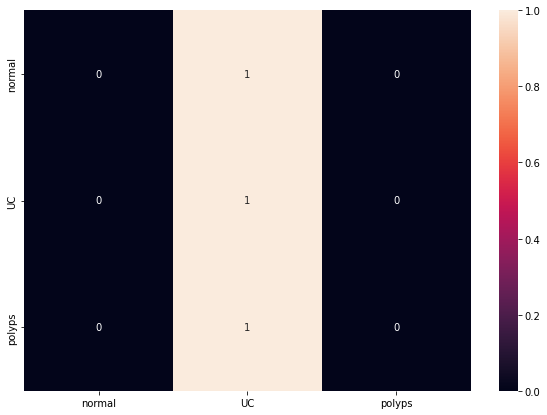

In [29]:
df_cm_2 = pd.DataFrame(cm_2, index = classes, columns = classes)
plt.figure(figsize = (10, 7))
cm_plot_2 = sns.heatmap(df_cm_2, annot = True);

In [ ]:
cm_plot_2.figure.savefig("cm_baseline_2.png")